##  1. Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import logging
import requests
import datetime

# Google Sheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

##  2. Fetch Stock Data

In [49]:
def fetch_stock_data(ticker, period="24mo", interval="1d"):
    data = yf.download(ticker, period=period, interval=interval)
    data.dropna(inplace=True)
    return data

tickers = ['INFY.NS', 'TCS.NS', 'RELIANCE.NS']
df_raw = fetch_stock_data(tickers[0])
df_raw.tail()

C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
Date,,,,,
2025-07-29,1513.699951,1517.199951,1496.099976,1512.900024,7070448
2025-07-30,1519.000000,1521.699951,1506.000000,1519.900024,5719051
2025-07-31,1509.000000,1527.099976,1497.000000,1509.699951,6851407
2025-08-01,1469.599976,1498.699951,1465.500000,1493.900024,8702978
2025-08-04,1478.000000,1482.800049,1451.000000,1461.500000,8590297


##  3. Feature Engineering

In [50]:
def add_indicators(df):
    close_series = df['Close'].squeeze()  # ensure 1D Series
    rsi = ta.momentum.RSIIndicator(close_series).rsi()
    macd_calc = ta.trend.MACD(close_series)

    df['rsi'] = rsi
    df['20dma'] = close_series.rolling(20).mean()
    df['50dma'] = close_series.rolling(50).mean()
    df['macd'] = macd_calc.macd()
    df['macd_signal'] = macd_calc.macd_signal()
    df.dropna(inplace=True)
    return df


In [51]:
df_indicators = add_indicators(df_raw)
df_indicators[['Close', 'rsi', '20dma', '50dma', 'macd', 'macd_signal']].tail()


Price,Close,rsi,20dma,50dma,macd,macd_signal
Ticker,INFY.NS,,,,,
Date,,,,,,
2025-07-29,1513.699951,32.118653,1587.049994,1585.354634,-18.410624,-7.392831
2025-07-30,1519.000000,34.120385,1582.474994,1584.799890,-20.096039,-9.933473
2025-07-31,1509.000000,32.191520,1576.989996,1584.459319,-21.985228,-12.343824
2025-08-01,1469.599976,25.963703,1568.434998,1582.989546,-26.357839,-15.146627
2025-08-04,1478.000000,29.112418,1560.984998,1581.378132,-28.813212,-17.879944


##  4. Strategy Logic & Backtesting

In [58]:


def generate_signals(df):
    """Generate buy/sell signals based on RSI and DMA crossover logic."""
    df = df.copy()
    df['buy_signal'] = (df['rsi'] < 35) & (df['20dma'] > df['50dma'])
    df['sell_signal'] = (df['rsi'] > 65) & (df['20dma'] < df['50dma'])

    # Ensure boolean dtype to avoid ambiguity errors
    df['buy_signal'] = df['buy_signal'].fillna(False).astype(bool)
    df['sell_signal'] = df['sell_signal'].fillna(False).astype(bool)

    # Create 'signal' column: 1 for buy, -1 for sell, 0 otherwise
    df['signal'] = 0
    df.loc[df['buy_signal'], 'signal'] = 1
    df.loc[df['sell_signal'], 'signal'] = -1

    print(f"✅ Buy signals: {df['buy_signal'].sum()}, Sell signals: {df['sell_signal'].sum()}")
    return df



In [61]:
import matplotlib.pyplot as plt

def plot_signals(df):
    """Plot stock prices with buy and sell signals."""
    plt.figure(figsize=(10, 5))
    plt.plot(df['Close'], label='Close Price', color='black')

    # Plot Buy signals
    plt.plot(df[df['buy_signal']].index, 
             df['Close'][df['buy_signal']], 
             '^', markersize=10, color='green', label='Buy Signal')

    # Plot Sell signals
    plt.plot(df[df['sell_signal']].index, 
             df['Close'][df['sell_signal']], 
             'v', markersize=10, color='red', label='Sell Signal')

    plt.title('Stock Price with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (₹)')
    plt.legend()
    plt.grid(True)
    plt.show()


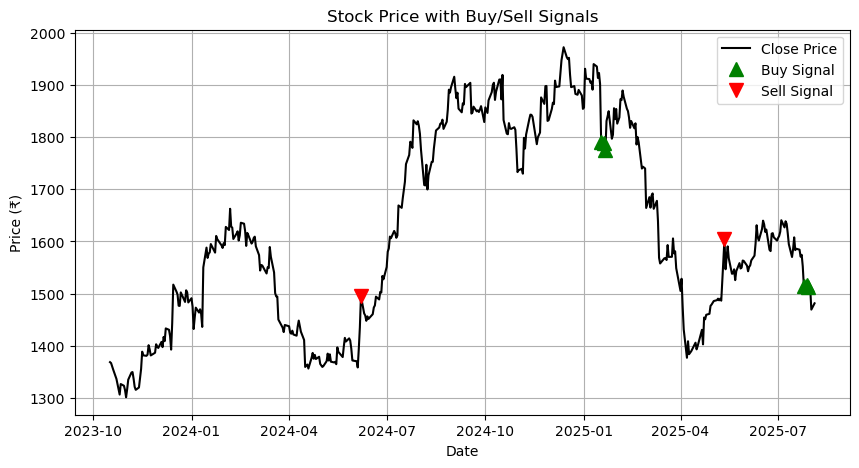

In [62]:
plot_signals(df_signals)

In [25]:
def backtest_strategy(df):
    """Backtest trading logic and return trade log, capital, return %, win rate."""
    capital = 100000.0
    position = 0.0
    buy_price = 0.0
    trade_log = []
    total_pnl = 0.0
    wins = 0
    losses = 0

    
    df = df.copy()
    df = df[df['Close'].notna()]  # remove NaN prices
    df['buy_signal'] = df['buy_signal'].astype(bool)
    df['sell_signal'] = df['sell_signal'].astype(bool)

    for idx in range(1, len(df)):
        buy_signal = df['buy_signal'].values[idx]
        sell_signal = df['sell_signal'].values[idx]
        close_price = float(df['Close'].values[idx])

        if buy_signal and position == 0:
            buy_price = close_price
            position = capital / buy_price
            trade_log.append((df.index[idx], 'BUY', round(buy_price, 2), 0.0))

        elif sell_signal and position > 0:
            sell_price = close_price
            pnl = (sell_price - buy_price) * position
            capital = position * sell_price
            trade_log.append((df.index[idx], 'SELL', round(sell_price, 2), round(pnl, 2)))
            total_pnl += pnl
            if pnl > 0:
                wins += 1
            else:
                losses += 1
            position = 0

    final_return_pct = ((capital - 100000.0) / 100000.0) * 100
    win_rate = (wins / (wins + losses)) * 100 if (wins + losses) > 0 else 0

    return trade_log, round(capital, 2), round(final_return_pct, 2), round(win_rate, 2)


In [26]:

stock_list = ['TCS.NS', 'INFY.NS', 'RELIANCE.NS', 'HDFCBANK.NS']  # Add any NSE tickers you want


In [27]:
all_trades = []

for stock in stock_list:
    df = fetch_stock_data(stock)
    df = add_indicators(df)
    df = generate_signals(df)

    # Backtest and unpack all returned values
    trades, capital, return_pct, win_rate = backtest_strategy(df)

    # Add stock name to each trade record
    stock_trades = [[stock, *t] for t in trades]
    all_trades.extend(stock_trades)

    print(f"📈 {stock} | Final Capital: ₹{capital:.2f} | Return: {return_pct:.2%} | Win Rate: {win_rate:.2%}")


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 8, Sell signals: 4
📈 TCS.NS | Final Capital: ₹83413.74 | Return: -1659.00% | Win Rate: 4615.00%


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 6, Sell signals: 2
📈 INFY.NS | Final Capital: ₹76110.83 | Return: -2389.00% | Win Rate: 4842.00%


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 7, Sell signals: 1
📈 RELIANCE.NS | Final Capital: ₹111274.25 | Return: 1127.00% | Win Rate: 5113.00%


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 11, Sell signals: 4
📈 HDFCBANK.NS | Final Capital: ₹124976.36 | Return: 2498.00% | Win Rate: 5611.00%


In [28]:
formatted_trades = [
    [
        row[0],  # Stock name
        str(row[1]) if isinstance(row[1], (pd.Timestamp, datetime.datetime)) else row[1],
        row[2],  # Action
        float(row[3]),  # Price
        float(row[4])   # P&L
    ] if len(row) == 5 else row
    for row in all_trades
]


In [45]:
log_to_google_sheets("AlgoTradeLogs", formatted_trades)


✅ Trades successfully logged to Google Sheets.


In [29]:
def prepare_ml_data(df):
    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    df.dropna(inplace=True)  # drop rows with NaNs before ML

    X = df[['rsi', 'macd', 'macd_signal', '20dma', '50dma', 'Volume',
            'price_change', 'rsi_diff', 'macd_diff',
            'volatility', 'return_3d', 'volume_surge']]
    y = df['target']
    return X, y


In [31]:
df_signals = generate_signals(df_indicators)
trades, final_capital, return_pct, win_rate = backtest_strategy(df_signals)

for t in trades:
    print(f"{t[0].date()} - {t[1]} at ₹{t[2]:.2f}" + (f", P&L: ₹{t[3]:.2f}" if t[1] == 'SELL' else ""))

print(f"\n📈 Final Capital: ₹{final_capital:.2f}")
print(f"📊 Total Return: {return_pct:.2f}%")
print(f"✅ Win Rate: {win_rate:.2f}%")


✅ Buy signals: 6, Sell signals: 2


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


2023-10-18 - BUY at ₹1367.19
2023-10-19 - SELL at ₹1360.65, P&L: ₹-478.99
2023-10-20 - BUY at ₹1354.57
2023-10-23 - SELL at ₹1336.92, P&L: ₹-1296.96
2023-10-25 - BUY at ₹1317.11
2023-10-26 - SELL at ₹1306.92, P&L: ₹-759.95
2023-10-27 - BUY at ₹1327.02
2023-10-30 - SELL at ₹1323.84, P&L: ₹-233.00
2023-10-31 - BUY at ₹1315.53
2023-11-01 - SELL at ₹1301.83, P&L: ₹-1012.53
2023-11-02 - BUY at ₹1317.21
2023-11-03 - SELL at ₹1335.38, P&L: ₹1327.25
2023-11-06 - BUY at ₹1349.08
2023-11-07 - SELL at ₹1350.04, P&L: ₹69.50
2023-11-08 - BUY at ₹1337.26
2023-11-09 - SELL at ₹1321.68, P&L: ₹-1136.86
2023-11-10 - BUY at ₹1315.96
2023-11-13 - SELL at ₹1320.48, P&L: ₹331.26
2023-11-15 - BUY at ₹1356.00
2023-11-16 - SELL at ₹1389.07, P&L: ₹2361.05
2023-11-17 - BUY at ₹1382.01
2023-11-20 - SELL at ₹1381.09, P&L: ₹-65.55
2023-11-21 - BUY at ₹1383.40
2023-11-22 - SELL at ₹1401.47, P&L: ₹1294.78
2023-11-23 - BUY at ₹1393.25
2023-11-24 - SELL at ₹1381.86, P&L: ₹-820.93
2023-11-28 - BUY at ₹1386.96
2023-11-29

##  5. ML Model: Predict Next-Day Movement

In [39]:
def add_engineered_features(df):
    df['price_change'] = df['Close'].pct_change()
    df['rsi_diff'] = df['rsi'].diff()
    df['macd_diff'] = df['macd'] - df['macd_signal']
    df['volatility'] = df['Close'].rolling(window=5).std()
    df['return_3d'] = df['Close'].pct_change(periods=3)
    df['volume_surge'] = df['Volume'] / df['Volume'].rolling(window=5).mean()
    return df


In [40]:
df_signals = add_engineered_features(df_signals)
X, y = prepare_ml_data(df_signals)
model = train_best_model(X, y)


C:\Users\shali\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:19:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final XGBoost Accuracy: 0.49

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.51      0.49        53
           1       0.51      0.47      0.49        58

    accuracy                           0.49       111
   macro avg       0.49      0.49      0.49       111
weighted avg       0.49      0.49      0.49       111



In [41]:
def prepare_ml_data(df):
    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    X = df[['rsi', 'macd', 'macd_signal', '20dma', '50dma', 'Volume',
            'price_change', 'rsi_diff', 'macd_diff',
            'volatility', 'return_3d', 'volume_surge']]

    y = df['target']
    return X, y


In [42]:
# !pip install xgboost

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def train_best_model(X, y):
    # Ensure non-empty data
    if len(X) < 10 or len(y) < 10:
        print("⚠️ Not enough data to train model.")
        return None

    # Drop last row to align with future price movement
    X = X[:-1]
    y = y[:-1]

    # Check alignment again
    if len(X) < 10:
        print("⚠️ Still not enough data after slicing.")
        return None

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    # Handle imbalance
    pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)

    model = XGBClassifier(
        n_estimators=250,
        max_depth=4,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.7,
        scale_pos_weight=pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Final XGBoost Accuracy: {acc:.2f}")
    print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred))

    return model


In [43]:
X, y = prepare_ml_data(df_signals)  # your existing function
model = train_best_model(X, y)      # this will print output


C:\Users\shali\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:19:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final XGBoost Accuracy: 0.49

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.51      0.49        53
           1       0.51      0.47      0.49        58

    accuracy                           0.49       111
   macro avg       0.49      0.49      0.49       111
weighted avg       0.49      0.49      0.49       111



In [35]:
#import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]
    sorted_names = [feature_names[i] for i in sorted_idx]

    plt.figure(figsize=(10, 4))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[sorted_idx], align='center', color='green')
    plt.xticks(range(len(importances)), sorted_names, rotation=45)
    plt.tight_layout()
    plt.show()

# After training:
# plot_feature_importance(model, X.columns)


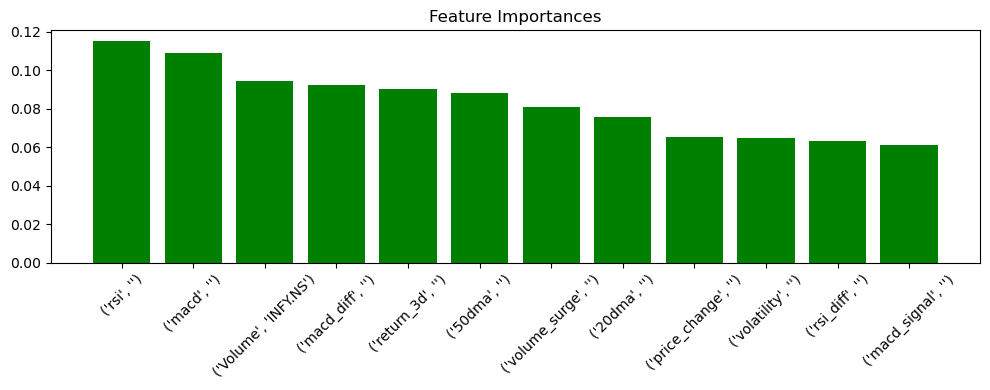

In [36]:
plot_feature_importance(model, X.columns)

##  6. Google Sheets Integration

In [44]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

def log_to_google_sheets(sheet_name, data, worksheet_name='TradeLog'):
    scope = ['https://www.googleapis.com/auth/spreadsheets',
             'https://www.googleapis.com/auth/drive']
    
    creds = ServiceAccountCredentials.from_json_keyfile_name(r"C:\Users\shali\Downloads\credentials.json", scope)
    client = gspread.authorize(creds)

    try:
        sheet = client.open(sheet_name)
    except gspread.exceptions.SpreadsheetNotFound:
        sheet = client.create(sheet_name)

    try:
        worksheet = sheet.worksheet(worksheet_name)
    except gspread.exceptions.WorksheetNotFound:
        worksheet = sheet.add_worksheet(title=worksheet_name, rows="1000", cols="20")

    # Add header if sheet is empty
    if not worksheet.get_all_values():
        headers = ['Date', 'Action', 'Price', 'P&L']
        worksheet.append_row(headers)

    # Format all trade rows first
    formatted_data = [
        [str(row[0].date()) if hasattr(row[0], 'date') else row[0]] + list(row[1:])
        for row in data
    ]

    # Append all rows in a single call
    worksheet.append_rows(formatted_data, value_input_option='USER_ENTERED')

    print("✅ Trades successfully logged to Google Sheets.")


##  7. Telegram Alerts

In [65]:
# Fill these in from your BotFather and getUpdates
bot_token = "8486923427:AAEIlhQtguUfoqFAOFSeyIJ55ZVvzOI5mI4"

chat_id = "5810339540"

# Example usage
send_telegram_message("📈 BUY signal for TCS at ₹3520", bot_token, chat_id)


📬 Message sent successfully.


In [64]:
import requests

def send_telegram_message(message, bot_token, chat_id):
    url = f"https://api.telegram.org/bot{bot_token}/sendMessage"
    payload = {
        'chat_id': chat_id,
        'text': message,
        'parse_mode': 'HTML'
    }
    response = requests.post(url, data=payload)
    
    if response.status_code == 200:
        print("📬 Message sent successfully.")
    else:
        print(f"❌ Failed to send message: {response.text}")


##  8. Full Execution for All 3 Stocks

In [46]:
all_trades = []

for stock in stock_list:
    df = fetch_stock_data(stock)
    df = add_indicators(df)
    df = generate_signals(df)

    trades, capital, return_pct, win_rate = backtest_strategy(df)  # ✅ Updated line

    stock_trades = [[stock, *t] for t in trades]
    all_trades.extend(stock_trades)

    print(f"📈 {stock} | Final Capital: ₹{capital:.2f} | Return: {return_pct:.2%} | Win Rate: {win_rate:.2%}")


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 8, Sell signals: 4
📈 TCS.NS | Final Capital: ₹83413.77 | Return: -1659.00% | Win Rate: 4615.00%


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 6, Sell signals: 2
📈 INFY.NS | Final Capital: ₹76110.82 | Return: -2389.00% | Win Rate: 4842.00%


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 7, Sell signals: 1
📈 RELIANCE.NS | Final Capital: ₹111274.25 | Return: 1127.00% | Win Rate: 5113.00%


C:\Users\shali\AppData\Local\Temp\ipykernel_15552\18276798.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\shali\AppData\Local\Temp\ipykernel_15552\1915698242.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  close_price = float(df['Close'].values[idx])


✅ Buy signals: 11, Sell signals: 4
📈 HDFCBANK.NS | Final Capital: ₹124976.36 | Return: 2498.00% | Win Rate: 5611.00%
